# Background
## Setup
State space: integers from 0 to 20 sampled uniformly

Utterance space: all possible closed integer intervals within the state space that have a minimum range of 3 and maximum range of 5:

\begin{align*}
\mathcal{S} &= \{0, 1, \dots, 20\} \\
\mathcal{U} &= \{[0, 2], [0, 3], [0, 4], \dots, [16, 20], [17, 20], [18, 20] \}
\end{align*}

## Literal Listener: L_0
$$L_0(s \mid u) \propto [[u]](s) P(s) $$

\begin{align*}
    [[u]](s) &=
    \left\{
    \begin{aligned}
        1 &\quad \text{if } a \leq s \leq b \\
        0 &\quad \text{else}
    \end{aligned} \quad \text{where } u=[a,b]
    \right. \\
\end{align*}

## Pragmatic Speaker 1: S_1

We have $\alpha$ the rationality parameter, $\psi$ the speaker type (inf, pers+, pers-), and $\beta$ that switches between inf and pers (+ or -) (they do not use intermediate $\beta$ values in the RSA opinion dynamics paper)

Persuasive strength does not depend on the state, and it gives more weight to utterances that have high or low expected value (relative to the literal listener) depending on pers+ or pers-. 

I assign 0 probability for utterances with 0 informativity, so truth condition is satisfied for both values of $\beta$.

\begin{align*}
    S_1(u | s, \psi) &\propto \text{Inf}_{S_1}(u ; s)^{\alpha\beta} \cdot \text{PersStr}_{S_1}(u; \psi) ^{\alpha(1 - \beta)} \\
    \text{Inf}_{S_1}(u ; s) &= L_0(s | u) \\
    \text{PersStr}_{S_1}(u ; \psi) &=
    \left\{
    \begin{aligned}
        \frac{E_{L_0}[s | u] - \text{min}(S)}{\text{max}(S) - \text{min}(S)} &\quad \text{if } \psi = \text{pers}^+ \\
        \frac{\text{max}(S) - E_{L_0}[s | u]}{\text{max}(S) - \text{min}(S)} &\quad \text{if } \psi = \text{pers}^-\\
        1 &\quad \text{if } \psi = \text{inf}
    \end{aligned}
    \right. \\
    \beta &=
    \left\{
    \begin{aligned}
        1 &\quad \text{if } \psi = \text{inf} \\
        0 &\quad \text{otherwise}
    \end{aligned}
    \right. \\
\end{align*}

## Pragmatic Listener 1 (informative): L_1^{inf}

This is the standard pragmatic listener. Assumes the speaker is informative:

$$L_1^{\text{inf}}(s \mid u) \propto L_1(s) \cdot S_1(u \mid s, \text{"inf"})$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

def create_all_utterances(min_interval, max_interval, domain):
    min_val, max_val = domain
    domain_range = max_val - min_val + 1
    if min_interval < 1 or max_interval > domain_range or min_interval >= max_interval:
        raise ValueError("Interval out of bounds of the domain.")
    utterances = []
    for interval_range in range(min_interval, max_interval + 1):
        for start in range(min_val, max_val + 1):
            end = start + interval_range - 1
            if end <= max_val:
                utterances.append((start, end))
                
    return utterances

def literal_listener(utterance, domain):
    min_val, max_val = domain
    start, end = utterance
    if start < min_val or end > max_val or start > end:
        raise ValueError("Utterance out of bounds of the domain.")
    x = list(range(min_val, max_val + 1))
    pmf = np.zeros(len(x))
    pmf[start: end + 1] = 1 / (end - start + 1)
    return x, pmf

# def literal_listener(utterance, domain):
#     if utterance == 0:
#         return [0, 1, 2, 3], np.array([0.5, 0, 0.25, 0.25])
#     else:
#         return [0, 1, 2, 3], np.array([0.5, 0.5, 0, 0])

def literal_speaker(state, utterances, domain):
    result = {u: 0.0 for u in utterances}
    for utt in utterances:
        x, pmf = literal_listener(utt, domain)
        x = np.array(x)
        if pmf[np.where(x == state)[0][0]] > 0:
            result[utt] += 1
    result = {k: v / sum(result.values()) for k, v in result.items()}
    return result

def informativeness_all_utterances(state, utterances, domain):

    result = {}
    for utt in utterances:
        x, pmf = literal_listener(utt, domain)
        x = np.array(x)
        pmf = np.array(pmf)
        result[utt] = pmf[np.where(x == state)[0][0]]
    return result

def persuasiveness_all_utterances(pers, utterances, domain):
        
    result = {u: 0.0 for u in utterances}

    for utt in utterances:
        if pers == "inf":
            result[utt] = 1
        else:
            x, pmf = literal_listener(utt, domain)
            for i in range(len(pmf)):
                result[utt] += x[i] * pmf[i]
            result[utt] = (result[utt] - domain[0])/ (domain[1] - domain[0])
            if pers == "low":
                result[utt] = 1 - result[utt]
    return result

def pragmatic_speaker(state, pers, utterances, domain, alpha=1.0):
    # Compute informativeness and persuasiveness
    informativeness = informativeness_all_utterances(state, utterances, domain)
    persuasiveness = persuasiveness_all_utterances(pers, utterances, domain)

    if pers == "inf":
        beta = 1.0
    else:
        beta = 0.0
        
    scores = []
    for utt in utterances:
        info = informativeness.get(utt, 0.0)
        pers_val = persuasiveness.get(utt, 0.0)

        if info > 0:
            score = (info ** (alpha * beta)) * (pers_val ** (alpha * (1 - beta)))
        else:
            score = 0.0
        scores.append(score)

    scores = np.array(scores)
    probs = scores / np.sum(scores) if np.sum(scores) > 0 else np.ones_like(scores) / len(scores)
    return {utt: p for utt, p in zip(utterances, probs)}

def pragmatic_listener(utt, utterances, domain, psi_prior, alpha):
    state_prior = 1.0 / (domain[1] - domain[0] + 1)
    x = []
    pmf = []
    # inf case
    all_states = np.arange(domain[0], domain[1] + 1)
    for state in all_states:
        res = 0
        for psi, psi_prob in psi_prior.items():
            res += pragmatic_speaker(state, psi, utterances, domain, alpha)[utt] * psi_prob 
        x.append(state)
        pmf.append(res * state_prior)
    pmf = np.array(pmf)
    pmf /= np.sum(pmf)
    return x, pmf

def pragmatic_listener_inf(utt, utterances, domain, alpha=3.0):
    state_prior = 1.0 / (domain[1] - domain[0] + 1)
    x = []
    pmf = []
    # inf case
    all_states = np.arange(domain[0], domain[1] + 1)
    for state in all_states:
        res_inf = pragmatic_speaker(state, "inf", utterances, domain, alpha=alpha)[utt]
        x.append(state)
        pmf.append(res_inf * state_prior)
    pmf = np.array(pmf)
    pmf /= np.sum(pmf)
    return x, pmf

def pragmatic_listener_op(utt, utterances, domain, psi_prior, alpha):
    state_prior = 1.0 / (domain[1] - domain[0] + 1)
    result = {"inf": 0.0, "high": 0.0, "low": 0.0}
    # op case
    all_states = np.arange(domain[0], domain[1] + 1)
    for psi, prob in psi_prior.items():
        for state in all_states:
            result[psi] += pragmatic_speaker(state, psi, utterances, domain, alpha=alpha)[utt] * state_prior * prob
    return result

# Calculating Suspicion

To calculate the suspicion, we first get the posterior probabilities for all utterances after the pragmatic listener hears an utterance $u^*$:
$$P(u' | u^*) = \sum_{s \in \mathcal{S}} S_1(u'|s, \text{"inf"}) \cdot L_1^{\text{inf}}(s | u^*)$$

We define an entropy/inverse-precision of an utterance as the entropy of the literal listener's state distribution after hearing that utterance, let's denote it as $\text{Ent(u)}$:

$$\text{Ent(u)} = \sum_{s \in \mathcal{S}} \log_2(L_0(s | u)) \cdot L_0(s | u)$$

Using this posterior utterance probabilities, we get a distribution of entropy $E$, let's denote its PMF with $p_E(x)$.

$$p_E(x) = \sum_{u' \in \mathcal{U} \land \text{Ent}(u') = x} P(u' | u^*) $$

We want to calculate how surprising $\text{Ent}(u^*)$ considering the distribution $p_E(x)$, and use this surprisal as a quantity for suspicion towards persuasion. I may have misunderstood what we discussed as two different methods, but from what I understood, the first method is 1) the tail probability / p-value which is the method I understood firstly and found more intuitive.

1) tail probability / p-value is the probability that the speaker could have used an utterance with a lower entropy (higher precision) than $u^*$.
$$sus(u^*) \propto \sum_{x < \text{Ent}(u ^ *)} p_E(x)$$

I am not sure if I understood the second method correctly but to get a surprisal value we can use the 2) self-information / probability of $\text{Ent}(u ^ *)$ given $p_E(x)$. 

2) self-information / probability is the surprisal amount that $\text{Ent}(u ^ *)$ carries:
$$sus(u^*) \propto -\log_2(p_E(\text{Ent}(u ^ *))) \quad \text{ or } \quad sus(u^*) \propto \frac{1}{p_E(\text{Ent} (u ^ *))} \quad \text{ or } \quad sus(u^*) \propto 1 - p_E(\text{Ent}(u ^ *))$$

Is this what we want? or something else?

# P-value: at least as extreme as

Your suggestion:

Change

\begin{align}
sus(u^*) &\propto \sum_{x < \text{Ent}(u ^ *)} p_E(x) \tag{5} \\
&\text{ to} \nonumber \\
sus(u^*) &\propto \sum_{x \le \text{Ent}(u ^ *)} p_E(x) \tag{6}
\end{align}

I think it should be $<$ because $sus$ here should be interpreted as not the p-value, but 1 minus p-value. If we look at this as hypothesis testing, then I think our null hypothesis would be that the speaker is informative. If we use the entropy as a test statistics, then a more extreme value under the null hypothesis is high-entropy, so p-value corresponds to the sum of the right tail of $p_E$ with $\ge$. We reject the null hypothesis as p-value gets lower which is analogue to having higher suspicion against informativity where suspicion corresponds to 1 minus p-value which is the sum of the left tail of $p_E$ with $<$.

\begin{align}
\text{p-value} = \sum_{x \ge \text{Ent}(u ^ *)} p_E(x) \nonumber
\end{align}

# Prior vs Posterior

Your suggestion:

Change
\begin{align}
P(u' \mid u^*) &= \sum_{s \in \mathcal{S}} S_1(u' \mid s, \text{"inf"}) \cdot L_1^{\text{inf}}(s \mid u^*)\\
&\text{to} \nonumber \\
P(u' \mid u^*) &= \sum_{s \in \mathcal{S}} S_1(u' \mid s, \text{"inf"}) \cdot L_1^{\text{inf}}(s)
\end{align}

Given the prior for states, we can compute the prior utterance and prior entropy distributions as you mentioned in (2). However, I think there should not be conceptually a "prior suspicion value for an utterance" because computing suspicion for a specific utterance must include a reasoning like "If I hear utterance $u^*$, I should suspect this amount". I don't see why we would consider states that are known to be impossible under the precondition of computing suspicion that an utterance $u ^ *$ is heard. Do you have in mind what would the suspicion conceptually correspond to when we use (2)?

I think the problem (what I consider as a problem) (2) causes is evident when we have many low-precision utterances for most of the state space and high-precision utterances for a small part of the space. Consider the following utterance space for the same state space of $[0, 20]$ where we have high-precision utterances for the part of the state space $[0, 2]$ and low-precision utterances for the part $[3, 20]$:

$$\mathcal{U}_{alt} = \{[0, 0], [1, 1], [2, 2], [0, 2], [3, 12], [4, 13], \dots, [11, 20]\}$$

If we use (2), then we would have most of the mass in $p_E$ in $p_E(\text{Ent}([3, 12]))$ regardless of the utterance heard $u ^ *$. Suppose $u ^ * = [0, 2]$, then, some other part of the state space $[3, 20]$, which we should for sure know that is irrelevant after hearing $u ^ *$, will cause $sus(u ^ *)$ to be lower compared to a case where this irrelevant part of the state space have high precision utterances. Maybe, instead of using (2) directly in the p-value calculation, we can use some property of $P(u' | u^*)$ or $p_E$ calculated under (2) to get a baseline or a discount value for the suspicion amount which then would be used along with the p-value obtained using (1) when calculating suspicion for a heard utterance $u ^ *$.  

What I also found as a sensible alternative to compare with (1) is the below formulation that incorporates the truthfulness assumption:
\begin{align}
P(u' \mid u^*) = \sum_{s \in \mathcal{S}} S_1(u' \mid s, \text{"inf"}) \cdot L_0(s \mid u^*) \tag{3}
\end{align}
This should correspond to a reasoning like this:

- I don't know whether the speaker is inf or pers

- I know that the state the speaker observed is $s \in [[u ^*]]$ 

- Using prior state beliefs, I know the probability of each state happening

- $P(u' \mid u^*)$ is the probability that an informative speaker could have said $u'$ where I know $u ^ *$ is true, and nothing more.

Also, I think a more general posterior perspective instead of (1) is to use $L_1(s \mid u^*)$ instead of $L_1^{\text{inf}}(s \mid u^*)$:

\begin{align}
P(u' \mid u^*) &= \sum_{s \in \mathcal{S}} S_1(u' \mid s, \text{"inf"}) \cdot L_1(s \mid u^*) \tag{4} \\
&\text{where} \nonumber \\
L_1(s \mid u ^ *) &\propto L_1(s) \cdot \sum_{\psi'} S_1(u ^ * \mid s, \psi') \cdot L_1(\psi') \nonumber \\
&\text{compared to} \nonumber \\
L_1^{\text{inf}}(s \mid u ^ *) &\propto L_1(s) \cdot S_1(u ^*  \mid s, \text{"inf"}) \nonumber
\end{align}

Then we get (1) as a special case of (4) where we have $L_1(\psi = \text{inf}) = 1$, and in the general case $L_1$ incorporates their prior beliefs about the speaker type when computing the state probabilities and consequently when computing the suspicion. My intuition for comparing (3) and (4) is that in (3) the listener $L_1$ is uninformed about the speaker type whereas in (4) they are, and in the special case of (1) they are assuming full informativity. I am not sure how (3) and (4) can be interpreted in terms of unawareness of persuasion. For (4), can we say the assumption/prior of full informativity is exactly the total unawareness of persuasive context even though $L_1$ considers the possible value of $\psi = \text{pers}$ for the variable $\psi$? It also seems reasonable to me to say for (3) the listener is unaware of the persuasive context (actually more generally, unaware of speaker types or the variable $\psi$ or the possible values for the variable $\psi$), and this variable $\psi$ (or a new value $\text{pers}$ for the variable $\psi$) is added to the model, which they become aware of after doing a non-bayesian revision. 

# Calculating Suspicion

I will use three different methods to calculate $P(u' \mid u ^ *)$ written below:

\begin{align}
P_1(u' \mid u ^ *) &= \sum_{s \in \mathcal{S}} S_1(u' \mid s, \text{"inf"}) \cdot L_0(s) \\
P_2(u' \mid u ^ *) &= \sum_{s \in \mathcal{S}} S_1(u' \mid s, \text{"inf"}) \cdot L_0(s \mid u^*) \\
P_3(u' \mid u ^ *) &= \sum_{s \in \mathcal{S}} S_1(u' \mid s, \text{"inf"}) \cdot L_1(s \mid u^*) \\
\end{align}


I will use two different test statistics to compute suspicion for each method of calculating $P(u' \mid u ^ *)$. First one is the entropy where suspicion would correspond to hearing an utterance more precise / lower entropy than the heard utterance $u^*$, given $P(u' \mid u^*)$:
\begin{align*}
\text{Ent(u)} &= -\sum_{s \in \mathcal{S}} \log_2(L_0(s | u)) \cdot L_0(s | u) \\
p_E(x) &= \sum_{u' \in \mathcal{U} \land \text{Ent}(u') = x} P(u' | u^*) \\
sus(u^*) &= \sum_{x < \text{Ent}(u ^ *)} p_E(x)
\end{align*}

Second method is to use directly the distribution $P(u' \mid u^*)$ and the occurence probability of $u^*$ under this distribution to compute the suspicion where it corresponds to hearing an utterance that is more probable than $u^*$ under $P(u' \mid u^*)$:

\begin{align*}
\mathcal{U}_{>u^*} &= \{u' \mid P(u' \mid u^*) > P(u^*|u^*)\} \\
sus(u^*) &= \sum_{u' \in \mathcal{U}_{\le u^*}} P(u' \mid u^*) \\
\end{align*}

Better way:
\begin{align}
I^{>}_{n}(u, s) &= \{u' \in \mathcal{U} \mid S_n(u' | s, \text{"inf"}) > S_n(u \mid s, \text{"inf"})\} \nonumber \\
sus_{n+1}(u^*) &= \sum_{s \in \mathcal{S}} L_n(s \mid u ^*) \sum_{u' \in I^{>}_{n}(u^*, s)} S_n(u' \mid s, \text{"inf"}) \tag{4}
\end{align}


In [11]:
def get_utterance_prob_0(utt, utterances, domain):
    all_states = np.arange(domain[0], domain[1] + 1)
    prior = 1 / len(all_states)
    utterance_probs = {u: 0.0 for u in utterances}
    for state in all_states:
        speaker_probs = literal_speaker(state, utterances, domain)
        for u in utterances:
            utterance_probs[u] += prior * speaker_probs[u]
    return utterance_probs

def get_utterance_prob_1(utt, utterances, domain, alpha=3.0):
    all_states = np.arange(domain[0], domain[1] + 1)
    prior = 1 / len(all_states)
    utterance_probs = {u: 0.0 for u in utterances}
    for state in all_states:
        speaker_probs = pragmatic_speaker(state, "inf", utterances, domain, alpha=alpha)
        for u in utterances:
            utterance_probs[u] += prior * speaker_probs[u]
    return utterance_probs

def get_utterance_prob_2(utt, utterances, domain, alpha=3.0):
    all_states = np.arange(domain[0], domain[1] + 1)
    utterance_probs = {u: 0.0 for u in utterances}
    for state in all_states:
        x_state, pmf_state = literal_listener(utt, domain)
        speaker_probs = pragmatic_speaker(state, "inf", utterances, domain, alpha=alpha)
        for u in utterances:
            utterance_probs[u] += pmf_state[x_state.index(state)] * speaker_probs[u]
    return utterance_probs

def get_utterance_prob_3(utt, utterances, domain, psi_prior, alpha=3.0):
    all_states = np.arange(domain[0], domain[1] + 1)
    utterance_probs = {u: 0.0 for u in utterances}
    for state in all_states:
        x_state, pmf_state = pragmatic_listener(utt, utterances, domain, psi_prior=psi_prior, alpha=alpha)
        speaker_probs = pragmatic_speaker(state, "inf", utterances, domain, alpha=alpha)
        for u in utterances:
            utterance_probs[u] += pmf_state[x_state.index(state)] * speaker_probs[u]
    return utterance_probs

def get_entropy(utt, domain):
    x, pmf = literal_listener(utt, domain)
    pmf = pmf[pmf > 0]  # Filter out zero probabilities
    entropy = -np.sum(pmf * np.log2(pmf))
    return entropy

def get_entropy_dist(domain, utterance_prob):
    entropies = {}
    for u, prob in utterance_prob.items():
        entropy = get_entropy(u, domain)
        entropies[entropy] = entropies.get(entropy, 0) + prob
    x, pmf = zip(*sorted(entropies.items()))
    return x, pmf

def sus_entropy_l(utt, domain, entropy_dist):
    x_ent, pmf_ent = entropy_dist
    utt_ent = get_entropy(utt, domain)
    suspicion = 0
    for i in range(len(x_ent)):
        if np.isclose(x_ent[i], utt_ent, rtol=1e-9, atol=1e-12):
            continue
        elif x_ent[i] < utt_ent:
            suspicion += pmf_ent[i]
    return suspicion

def sus_probability(utt, utterance_prob):
    utt_prob = utterance_prob.get(utt, 0.0)
    suspicion = 0
    for u, prob in utterance_prob.items():
        if np.isclose(prob, utt_prob, rtol=1e-9, atol=1e-12):
            continue
        elif prob > utt_prob:
            suspicion += prob
    return suspicion

def sus_proper(utt, utterances, domain, alpha=1.0):
    all_states = np.arange(domain[0], domain[1] + 1)
    sus = 0.0
    listener_x, listener_pmf = literal_listener(utt, domain)
    for state in all_states:
        speaker_result = pragmatic_speaker(state, "inf", utterances, domain, alpha=alpha)
        for u, prob in speaker_result.items():
            if np.isclose(prob, speaker_result[utt], rtol=1e-9, atol=1e-12):
                continue
            elif prob > speaker_result[utt]:
                sus += prob * listener_pmf[listener_x.index(state)]
    return sus

def sus_proper(utt, utterances, domain, alpha=1.0):
    all_states = np.arange(domain[0], domain[1] + 1)
    result_psi = {"inf": 1.0, "high": 0.0, "low": 0.0}
    sus = 0.0
    high_result = persuasiveness_all_utterances("high", utterances, domain)
    low_result = persuasiveness_all_utterances("low", utterances, domain)
    listener_x, listener_pmf = literal_listener(utt, domain)
    for state in all_states:
        speaker_result = pragmatic_speaker(state, "inf", utterances, domain, alpha=alpha)
        for u, prob in speaker_result.items():
            if np.isclose(prob, speaker_result[utt], rtol=1e-9, atol=1e-12):
                continue
            elif prob > speaker_result[utt]:
                sus += prob * listener_pmf[listener_x.index(state)]
                result_psi["inf"] -= sus
                if np.isclose(high_result[u], low_result[u], rtol=1e-9, atol=1e-12):
                    result_psi["high"] += sus / 2.0
                    result_psi["low"] += sus / 2.0
                else:
                    if high_result[u] > low_result[u]:
                        result_psi["high"] += sus
                    else:
                        result_psi["low"] += sus
    return sus, result_psi

In [ ]:
utterances = [0, 1]
literal_listener(0, (0, 3))
pragmatic_speaker(3, "inf", utterances, (0, 3), alpha=1.0)
pragmatic_listener(1, utterances, (0, 3), psi_prior={"inf": 1.0, "high": 0.0, "low": 0.0}, alpha=4.0)

print(sus_proper(0, utterances, (0, 3), alpha=1.0))
res_1 = get_utterance_prob_2(0, utterances, (0, 3), alpha=1.0)
print(sus_entropy_l(0, (0, 3), get_entropy_dist((0, 3), res_1)))



KeyError: (1, 7)

In [14]:
min_interval = 3
max_interval = 5
domain = (0, 20)
utterances = create_all_utterances(min_interval, max_interval, domain)
utterance = (1, 3)
psi_prior = {"inf": 1.0, "high": 0.0, "low": 0.0}

res_1 = get_utterance_prob_1(utterance, utterances, domain, alpha=5.0)
res_2 = get_utterance_prob_2(utterance, utterances, domain, alpha=5.0)
res_3 = get_utterance_prob_3(utterance, utterances, domain, psi_prior, alpha=5.0)

for utt, prob in res_1.items():
    print(f"Utterance: {utt}, Probability: {prob}")

entropy_dist = get_entropy_dist(domain, res_1)
sus_entropy_l_value = sus_entropy_l(utterance, domain, entropy_dist)
sus_prob = sus_probability(utterance, res_1)
print(f"Utterance: {utterance}, Suspicion Entropy Value: {sus_entropy_l_value}")
print(f"Utterance: {utterance}, Suspicion Probability: {sus_prob}")


Utterance: (0, 2), Probability: 0.06638577412305985
Utterance: (1, 3), Probability: 0.04135285315125242
Utterance: (2, 4), Probability: 0.03422478398105448
Utterance: (3, 5), Probability: 0.03313178518568016
Utterance: (4, 6), Probability: 0.03293142586281879
Utterance: (5, 7), Probability: 0.03293142586281879
Utterance: (6, 8), Probability: 0.03293142586281879
Utterance: (7, 9), Probability: 0.03293142586281879
Utterance: (8, 10), Probability: 0.03293142586281879
Utterance: (9, 11), Probability: 0.03293142586281879
Utterance: (10, 12), Probability: 0.03293142586281879
Utterance: (11, 13), Probability: 0.03293142586281879
Utterance: (12, 14), Probability: 0.03293142586281879
Utterance: (13, 15), Probability: 0.03293142586281878
Utterance: (14, 16), Probability: 0.03293142586281878
Utterance: (15, 17), Probability: 0.03313178518568016
Utterance: (16, 18), Probability: 0.03422478398105448
Utterance: (17, 19), Probability: 0.04135285315125242
Utterance: (18, 20), Probability: 0.0663857741

In [8]:
def pretty_table(df, sort_by=None, top_n=10, decimals=3):
    """
    Display a nice-looking table of suspicion results.

    Args:
        df (pd.DataFrame): Results DataFrame
        sort_by (str, optional): Column to sort by
        top_n (int): Number of rows to show
        decimals (int): Rounding of floats

    Returns:
        pd.DataFrame (console) or pd.Styler (Jupyter)
    """
    # Round floats
    #df = df.round(decimals)

    # Optional sort
    if sort_by and sort_by in df.columns:
        df = df.sort_values(by=sort_by, ascending=False)

    # Limit rows
    df = df.head(top_n)

    try:
        # Jupyter pretty table with gradient
        return df.style.background_gradient(cmap="Blues")
    except Exception:
        # Fallback for console
        pd.set_option("display.max_columns", None)
        pd.set_option("display.width", 150)
        return df

In [15]:
import pandas as pd

UTT_PROB_METHODS = {
    # "p(u' | u*)_0": lambda utt, utterances, domain, psi_prior, alpha:
    #     get_utterance_prob_0(utt, utterances, domain),
    "1": lambda utt, utterances, domain, psi_prior, alpha:
        get_utterance_prob_1(utt, utterances, domain, alpha),
    "2": lambda utt, utterances, domain, psi_prior, alpha:
        get_utterance_prob_2(utt, utterances, domain, alpha),
    "3": lambda utt, utterances, domain, psi_prior, alpha:
        get_utterance_prob_3(utt, utterances, domain, psi_prior, alpha),
}

SUSPICION_METHODS = {
    "entropy": lambda utt, domain, utterance_prob:
        sus_entropy_l(utt, domain, get_entropy_dist(domain, utterance_prob)),
    "probability": lambda utt, domain, utterance_prob:
        sus_probability(utt, utterance_prob),
}

def compute_all_suspicions(utterances, domain, psi_prior, alpha=5.0):
    results = []
    for utt in utterances:
        row = {"utterance": utt}
        for prob_name, prob_func in UTT_PROB_METHODS.items():
            utterance_prob = prob_func(utt, utterances, domain, psi_prior, alpha)
            for sus_name, sus_func in SUSPICION_METHODS.items():
                key = f"{prob_name} - {sus_name}"
                row[key] = sus_func(utt, domain, utterance_prob)
        results.append(row)
    return pd.DataFrame(results)

min_interval = 3
max_interval = 5
domain = (0, 19)
domain = (0, 7)
alpha = 3.0
utterances = create_all_utterances(min_interval, max_interval, domain)
#utterances = [(0, 0), (1, 19), (0, 18), (10, 19), (0, 9), (19, 19)]
utterances = [(0, 0), (1, 7), (0, 6), (4, 7), (0, 3), (7, 7)]
# utterances = [(0, 0), (1, 1), (2, 2), (0, 2)]

# for i in range(3, 12):
#     utterances.append((i, i + 9))
psi_prior = {"inf": 1.0, "high": 0.0, "low": 0.0}

proper_result = []
for utt in utterances:
    proper_result.append(sus_proper(utt, utterances, domain, alpha=alpha))
    #print(f"Utterance: {utt}, Suspicion: {sus_proper(utt, utterances, domain, alpha=alpha)}")

df = compute_all_suspicions(utterances, domain, psi_prior, alpha=alpha).head(100)
df["Last Method"] = proper_result

df.style.background_gradient(cmap="Blues", vmin=0, vmax=1).format(precision=3).set_table_styles([
       {"selector": "th", "props": [("font-size", "15pt"), ("text-align", "center")]},  
       {"selector": "td", "props": [("font-size", "18pt"), ("text-align", "center"), ("width", "150px")]},    
        {"selector": "tr", "props": [("height", "50px")]}   
   ])

,utterance,1 - entropy,1 - probability,2 - entropy,2 - probability,3 - entropy,3 - probability,Last Method
0,"(0, 0)",0.000,0.550,0.000,0.000,0.000,0.000,"(np.float64(0.0), {'inf': np.float64(1.0), 'high': np.float64(0.0), 'low': np.float64(0.0)})"
1,"(1, 7)",0.795,0.795,0.767,0.767,0.729,0.726,"(np.float64(0.7666520527934004), {'inf': np.float64(-2.5777607614938964), 'high': np.float64(2.9535569398378456), 'low': np.float64(0.624203821656051)})"
2,"(0, 6)",0.795,0.795,0.767,0.767,0.729,0.726,"(np.float64(0.7666520527934004), {'inf': np.float64(-4.622063872026909), 'high': np.float64(4.287810405932377), 'low': np.float64(1.3342534660945318)})"
3,"(4, 7)",0.245,0.000,0.245,0.000,0.007,0.000,"(np.float64(0.2454492598058947), {'inf': np.float64(0.7545507401941053), 'high': np.float64(0.2454492598058947), 'low': np.float64(0.0)})"
4,"(0, 3)",0.245,0.000,0.245,0.000,0.007,0.000,"(np.float64(0.2454492598058947), {'inf': np.float64(-2.190840377476631), 'high': np.float64(2.209043338253052), 'low': np.float64(0.9817970392235787)})"
5,"(7, 7)",0.000,0.550,0.000,0.000,0.000,0.000,"(np.float64(0.0), {'inf': np.float64(1.0), 'high': np.float64(0.0), 'low': np.float64(0.0)})"


In [18]:
utt = (1, 7)

x_1, pmf_1 = pragmatic_listener_inf(utt, utterances, domain, alpha=alpha)
susa, sus_psi_prior = sus_proper(utt, utterances, domain, alpha=alpha)
psi_prior = sus_psi_prior
print(psi_prior)

x, pmf = pragmatic_listener(utt, utterances, domain, psi_prior, alpha=alpha)
print(f"Suspicion proper: {susa}")

for state in x_1:
    print(f"State: {state}, Inf: {pmf_1[x_1.index(state)]}, Sus: {pmf[x.index(state)]}")

{'inf': np.float64(-2.5777607614938964), 'high': np.float64(2.9535569398378456), 'low': np.float64(0.624203821656051)}
Suspicion proper: 0.7666520527934004
State: 0, Inf: 0.0, Sus: 0.0
State: 1, Inf: 0.16608356545961003, Sus: 0.22256250291403168
State: 2, Inf: 0.16608356545961003, Sus: 0.22256250291403168
State: 3, Inf: 0.16608356545961003, Sus: 0.22256250291403168
State: 4, Inf: 0.16608356545961003, Sus: 0.07289696781089398
State: 5, Inf: 0.16608356545961003, Sus: 0.07289696781089398
State: 6, Inf: 0.16608356545961003, Sus: 0.07289696781089398
State: 7, Inf: 0.0034986072423398326, Sus: 0.11362158782522304


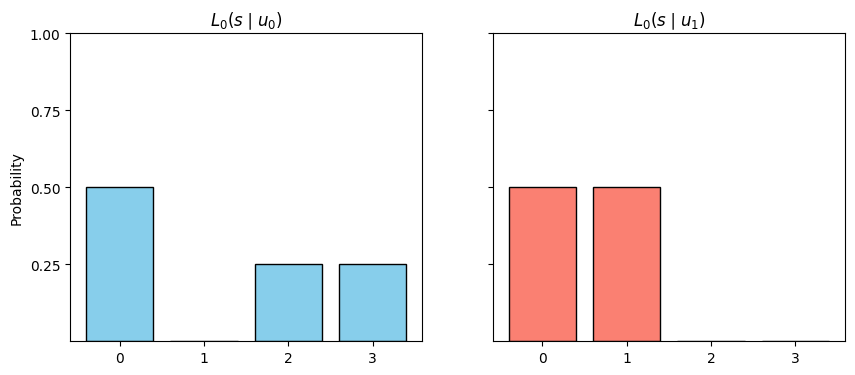

In [55]:
# X axis values (states)
x = np.array([0, 1, 2, 3])

# Probability distributions
L_u0 = [0.5, 0.0, 0.25, 0.25]
L_u1 = [0.5, 0.5, 0.0, 0.0]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# First distribution
axes[0].bar(x, L_u0, color="skyblue", edgecolor="black")
axes[0].set_title(r"$L_0(s \mid u_0)$")
axes[0].set_xticks(x)
axes[0].set_ylim(0, 0.6)
axes[0].set_ylabel("Probability")

axes[1].bar(x, L_u1, color="salmon", edgecolor="black")
axes[1].set_title(r"$L_0(s \mid u_1)$")
axes[1].set_xticks(x)
axes[1].set_ylim(0, 1)
plt.yticks([0.25, 0.50, 0.75, 1.0])
plt.show()

# How to 
\begin{equation}
S^* = \arg\min_{S} \Big[ D_{\mathrm{KL}}(S \,\|\, S_1) - D_{\mathrm{KL}}(S \,\|\, S_2) \Big]
\end{equation}

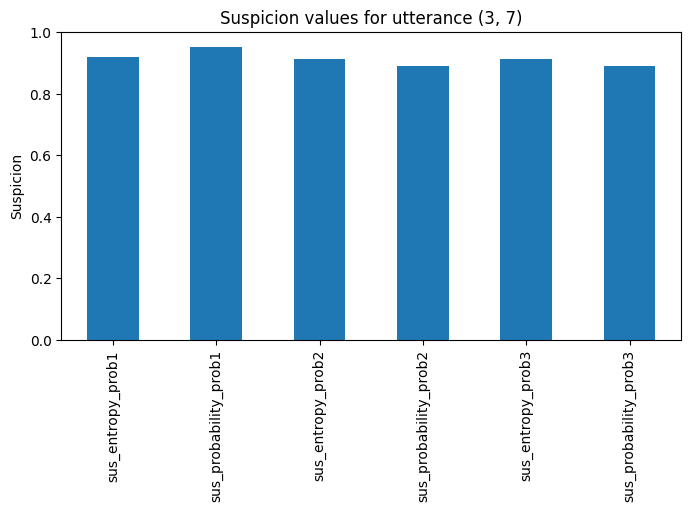

In [130]:
utt_idx = 40# e.g. first utterance
row = df.iloc[utt_idx].drop("utterance")

row.plot(kind="bar", figsize=(8,4))
plt.title(f"Suspicion values for utterance {df.iloc[utt_idx]['utterance']}")
plt.ylabel("Suspicion")
plt.show()

In [183]:
def pretty_table(df, sort_by=None, top_n=10, decimals=3):
    """
    Display a nice-looking table of suspicion results.

    Args:
        df (pd.DataFrame): Results DataFrame
        sort_by (str, optional): Column to sort by
        top_n (int): Number of rows to show
        decimals (int): Rounding of floats

    Returns:
        pd.DataFrame (console) or pd.Styler (Jupyter)
    """
    # Round floats
    #df = df.round(decimals)

    # Optional sort
    if sort_by and sort_by in df.columns:
        df = df.sort_values(by=sort_by, ascending=False)

    # Limit rows
    df = df.head(top_n)

    try:
        # Jupyter pretty table with gradient
        return df.style.background_gradient(cmap="Blues")
    except Exception:
        # Fallback for console
        pd.set_option("display.max_columns", None)
        pd.set_option("display.width", 150)
        return df
pretty_table(df, top_n=54)

,utterance,sus_entropy_prob1,sus_probability_prob1,sus_entropy_prob2,sus_probability_prob2,sus_entropy_prob3,sus_probability_prob3
0,"(0, 0)",0.000000,0.904763,0.000000,0.000000,0.000000,0.000000
1,"(1, 20)",0.897813,0.802576,0.892703,0.842704,0.500007,0.500006
2,"(0, 19)",0.897813,0.802576,0.892703,0.842704,0.500007,0.500006
3,"(11, 20)",0.095237,0.000000,0.099999,0.000000,0.000002,0.000000
4,"(0, 9)",0.095237,0.401288,0.099999,0.000000,0.000002,0.000000
5,"(20, 20)",0.000000,0.904763,0.000000,0.000000,0.000000,0.000000


In [2]:
def get_entropy(utt, domain):
    x, pmf = literal_listener(utt, domain)
    pmf = pmf[pmf > 0]  # Filter out zero probabilities
    entropy = -np.sum(pmf * np.log2(pmf))
    return entropy

def posterior_utterance_distribution(utt, utterances, domain, alpha=3.0):
    utterance_probs = {u: 0.0 for u in utterances}
    all_states = np.arange(domain[0], domain[1] + 1)
    for state in all_states:
        x_state, pmf_state = pragmatic_listener_inf(utt, utterances, domain, alpha=alpha)
        speaker_utt_probs = pragmatic_speaker(state, "inf", utterances, domain, alpha=alpha)
        for u in utterances:
            utterance_probs[u] += pmf_state[x_state.index(state)] * speaker_utt_probs[u]
            
    return utterance_probs

def entropy_distribution(utt, utterances, domain, alpha=3.0):
    utterance_probs = posterior_utterance_distribution(utt, utterances, domain, alpha=alpha)
    entropies = {}
    for u, prob in utterance_probs.items():
        entropy = get_entropy(u, domain)
        entropies[entropy] = entropies.get(entropy, 0) + prob
    x, pmf = zip(*sorted(entropies.items()))
    return x, pmf


In [4]:
def get_suspicion_pvalue(utt, utterances, domain, belief, alpha=3.0):
    x_ent, pmf_ent = entropy_distribution(utt, utterances, domain, alpha=alpha)
    utt_ent = get_entropy(utt, domain)
    suspicion = 0
    for i in range(len(x_ent)):
        if x_ent[i] < utt_ent:
            suspicion += pmf_ent[i]
    return suspicion